In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

In [31]:
# --- Constantes Globais ---
DATA_PATH = "hotel_base_limpa.xlsx"
COL_CANCELADO = "reserva_cancelada_bool"
COL_ANTECEDENCIA = "tempo_antecedencia"
COL_SEGMENTO = "segmento_mercado"
COL_AGENCIA = "agencia_turismo_cat"
COL_RECEITA_NOITE = "receita_por_noite"
COL_MES_CHEGADA = "mes_chegada"
COL_ANO_CHEGADA = "ano_chegada"
COL_FIDELIDADE = "cliente_recorrente"


# --- Funções Auxiliares ---
# Carrega os dados de um arquivo Excel e realiza pré-processamentos básicos. Retorna um DataFrame pronto para análise ou None em caso de erro.
def carregar_e_preparar_dados(path: str) -> Optional[pd.DataFrame]:
        
    try:
        df = pd.read_excel(path)  # leitura do arquivo Excel
        print(f"Arquivo carregado com sucesso: {path}")
        print("Dimensões:", df.shape)

        # Garante existência da coluna de cancelamento como booleana
        if "reserva_cancelada" in df.columns and COL_CANCELADO not in df.columns:
            df[COL_CANCELADO] = df["reserva_cancelada"].astype(bool)

        # Se mesmo assim não existir, lança erro
        if COL_CANCELADO not in df.columns:
            raise ValueError(f"Coluna de cancelamento '{COL_CANCELADO}' não encontrada.")
            
        # Cria coluna de total de noites se ainda não existir
        if "total_noites" not in df.columns:
            df["total_noites"] = df["nro_noites_fds"] + df["nro_noites_dds"]
            
        # Cria coluna de ano/mês como timestamp para facilitar análises temporais
        df["ano_mes"] = pd.to_datetime(
            df[COL_ANO_CHEGADA].astype(str) + "-" + df[COL_MES_CHEGADA].astype(str)
        )
        
        # Calcula receita total da reserva
        df["receita_total"] = df[COL_RECEITA_NOITE] * df["total_noites"]

        return df

    except FileNotFoundError:
        # Tratamento específico para arquivo inexistente
        print(f"Erro: Arquivo não encontrado no caminho: {path}")
        return None
    except Exception as e:
        # Tratamento genérico para outros erros inesperados
        print(f"Ocorreu um erro inesperado: {e}")
        return None

# Função genérica para criação de gráficos. Suporta tipos: 'bar', 'line' e 'pie'.
def plotar_grafico(kind, data, title, xlabel, ylabel, figsize=(8, 4), color=None, rotation=45, horizontal=False):
        
    plt.figure(figsize=figsize)

    # Se DataFrame, utiliza apenas a primeira coluna
    plot_data = data.iloc[:, 0] if isinstance(data, pd.DataFrame) else data
    
    # Geração do gráfico conforme tipo escolhido
    if kind == "bar":
        if horizontal:
            plot_data.plot(kind="barh", color=color)
        else:
            plot_data.plot(kind="bar", color=color)
        plt.xticks(rotation=rotation)

    elif kind == "line":
        plt.plot(plot_data.index, plot_data.values, marker="o")

    elif kind == "pie":
        plt.pie(plot_data.values, labels=plot_data.index, autopct="%.1f%%", startangle=90, colors=color)

    # Configurações visuais comuns a todos os gráficos
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


In [32]:
# A função já trata pré-processamento e possíveis erros.
df_original = carregar_e_preparar_dados(DATA_PATH)

# Verifica se o DataFrame foi carregado com sucesso
if df_original is not None:
    # Exibe as primeiras linhas do DataFrame para inspeção inicial dos dados.
    display(df_original.head())


Arquivo carregado com sucesso: hotel_base_limpa.xlsx
Dimensões: (32766, 24)


,reserva_cancelada,tempo_antecedencia,data_chegada,ano_chegada,mes_chegada,diadomes_chegada,nro_noites_fds,nro_noites_dds,adultos,criancas,...,agencia_turismo,receita_por_noite,pedidos_especiais,status_reserva,data_status_reserva,reserva_cancelada_bool,agencia_turismo_cat,total_noites,ano_mes,receita_total
0,1,75,1969-12-31 21:00:42.186,2015,7,1,0,3,2,0,...,15.0,105.5,0,Cancelada,1969-12-31 21:00:42.116,True,Com Agência,3,2015-07-01,316.5
1,1,85,1969-12-31 21:00:42.186,2015,7,1,0,3,2,0,...,240.0,82.0,1,Cancelada,1969-12-31 21:00:42.130,True,Com Agência,3,2015-07-01,246.0
2,1,60,1969-12-31 21:00:42.186,2015,7,1,2,5,2,0,...,240.0,107.0,2,Cancelada,1969-12-31 21:00:42.135,True,Com Agência,7,2015-07-01,749.0
3,1,96,1969-12-31 21:00:42.186,2015,7,1,2,8,2,0,...,NaN,108.3,2,Cancelada,1969-12-31 21:00:42.153,True,Reserva Direta,10,2015-07-01,1083.0
4,1,23,1969-12-31 21:00:42.186,2015,7,1,0,4,2,0,...,240.0,123.0,0,Cancelada,1969-12-31 21:00:42.178,True,Com Agência,4,2015-07-01,492.0



### 01 · Análise de Cancelamentos — Onde estamos perdendo receita?

---

In [33]:
# Verificação para garantir que a coluna existe
if COL_FIDELIDADE not in df_original.columns:
    print(f"ATENÇÃO: A coluna '{COL_FIDELIDADE}' não foi encontrada. Verifique o nome exato no seu DataFrame.")
else:
    # Mapear os valores 0 e 1 para rótulos mais claros para os gráficos e tabelas
    df_original['tipo_hospede'] = df_original[COL_FIDELIDADE].map({0: 'Primeira Reserva', 1: 'Cliente Recorrente'})
    print("Coluna 'tipo_hospede' criada a partir da coluna de fidelidade existente.")

Coluna 'tipo_hospede' criada a partir da coluna de fidelidade existente.


--- Análise de Cancelamento por Fidelidade do Cliente ---


,taxa_cancelamento_pct,n_reservas_total
tipo_hospede,,
Primeira Reserva,25.07548,31134
Cliente Recorrente,4.35049,1632


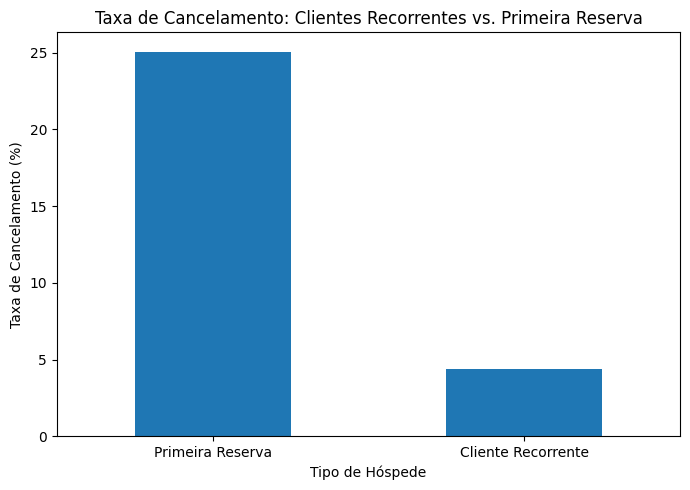

In [34]:
if 'tipo_hospede' in df_original.columns:
    print("--- Análise de Cancelamento por Fidelidade do Cliente ---")

    # Agrupar por tipo de hóspede e calcular a taxa de cancelamento e o N de reservas
    analise_cancelamento_fidelidade = df_original.groupby('tipo_hospede').agg(
        taxa_cancelamento_pct=(COL_CANCELADO, lambda x: x.mean() * 100),
        n_reservas_total=(COL_CANCELADO, 'size')
    ).sort_values('taxa_cancelamento_pct', ascending=False)
    
    display(analise_cancelamento_fidelidade)
    
    # Gerar gráfico de barras para visualização
    plotar_grafico(
        'bar', 
        analise_cancelamento_fidelidade['taxa_cancelamento_pct'],
        title='Taxa de Cancelamento: Clientes Recorrentes vs. Primeira Reserva',
        xlabel='Tipo de Hóspede',
        ylabel='Taxa de Cancelamento (%)',
        figsize=(7, 5),
        rotation=0
    )

Taxa de cancelamento geral: 24.04%

Taxa de cancelamento e N por faixa de antecedência:


,taxa_cancelamento_pct,n_reservas
faixa_antecedencia,,
0-3,5.584264,5999
4-7,7.614458,2075
8-14,14.915572,2132
15-30,25.014310,3494
31-60,29.779917,4362
61-90,30.987777,3027
91-180,32.578907,6495
181-365,35.887739,5024
366-730,23.566879,157


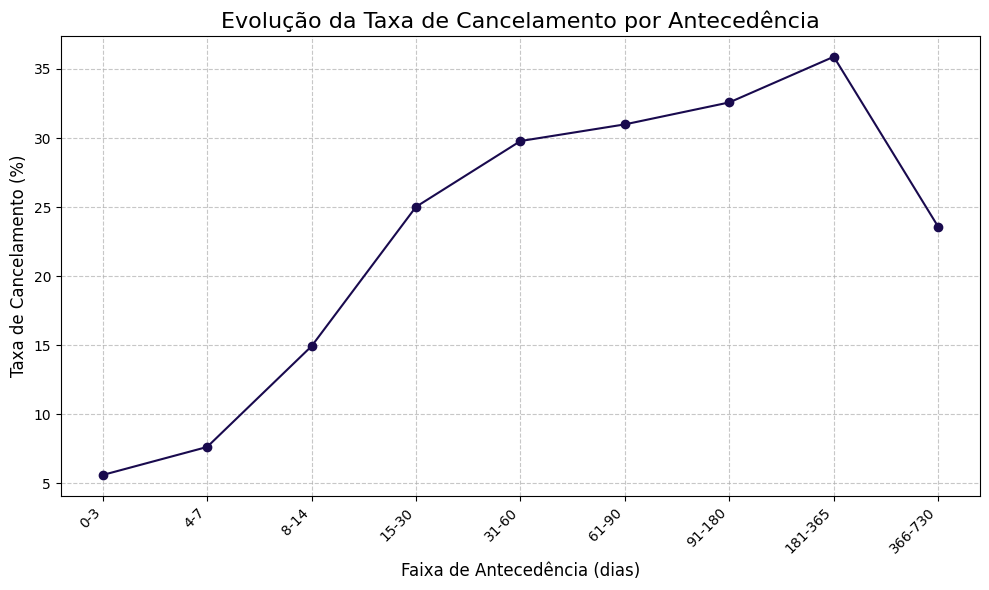


Taxa de cancelamento e N por Segmento de Mercado:


,taxa_cancelamento_pct,n_reservas
segmento_mercado,,
At Online,33.999150,16471
Grupos,22.634409,1860
Direta,13.395334,6129
Corporativo,13.166485,1838
At Offline,12.275819,6468


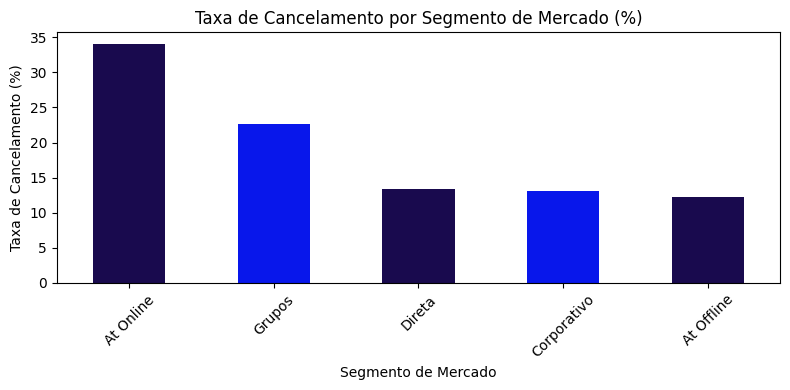


Taxa de cancelamento e N por Categoria de Agência:


,taxa_cancelamento_pct,n_reservas
agencia_turismo_cat,,
Com Agência,26.880676,26759
Não Informada,13.671730,2699
Reserva Direta,9.552600,3308


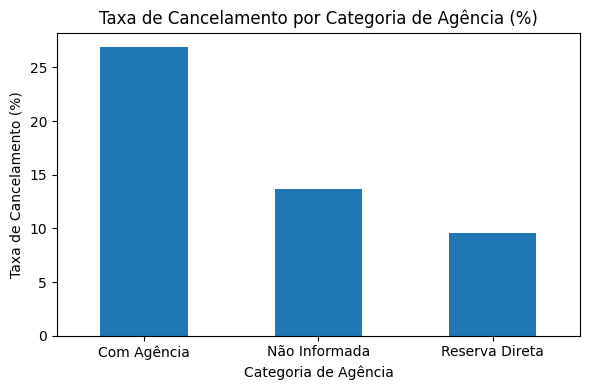

In [35]:
if df_original is not None:
    df = df_original.copy()
    
    #  Taxa Geral
    taxa_geral = df[COL_CANCELADO].mean() * 100
    print(f"Taxa de cancelamento geral: {taxa_geral:.2f}%\n")

    #  Por Antecedência (com N)
    bins = [0, 3, 7, 14, 30, 60, 90, 180, 365, 730]
    labels = ["0-3", "4-7", "8-14", "15-30", "31-60", "61-90", "91-180", "181-365", "366-730"]
    df['faixa_antecedencia'] = pd.cut(df[COL_ANTECEDENCIA], bins=bins, labels=labels, right=True, include_lowest=True)
    
    print("Taxa de cancelamento e N por faixa de antecedência:")
    analise_antecedencia = df.groupby('faixa_antecedencia', observed=True).agg(
        taxa_cancelamento_pct=(COL_CANCELADO, lambda x: x.mean() * 100),
        n_reservas=(COL_CANCELADO, 'size')
    )
    display(analise_antecedencia)
    plt.figure(figsize=(10, 6))
    plt.plot(
        analise_antecedencia.index.astype(str),  
        analise_antecedencia['taxa_cancelamento_pct'], 
        marker='o',  
        linestyle='-',  
        color='#190A4E' 
    )
    plt.title('Evolução da Taxa de Cancelamento por Antecedência', fontsize=16)
    plt.xlabel('Faixa de Antecedência (dias)', fontsize=12)
    plt.ylabel('Taxa de Cancelamento (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotação para não sobrepor os textos
    plt.grid(True, linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.show()
    
    #  Por Segmento e Agência (com N)
    print("\nTaxa de cancelamento e N por Segmento de Mercado:")
    analise_segmento = df.groupby(COL_SEGMENTO, observed=True).agg(
        taxa_cancelamento_pct=(COL_CANCELADO, lambda x: x.mean() * 100),
        n_reservas=(COL_CANCELADO, 'size')
    ).sort_values('taxa_cancelamento_pct', ascending=False)
    display(analise_segmento)
    plotar_grafico('bar', analise_segmento, 'Taxa de Cancelamento por Segmento de Mercado (%)', 'Segmento de Mercado', 'Taxa de Cancelamento (%)',color=["#190A4E", "#0817EB"])

    print("\nTaxa de cancelamento e N por Categoria de Agência:")
    analise_agencia = df.groupby(COL_AGENCIA, observed=True).agg(
        taxa_cancelamento_pct=(COL_CANCELADO, lambda x: x.mean() * 100),
        n_reservas=(COL_CANCELADO, 'size')
    ).sort_values('taxa_cancelamento_pct', ascending=False)
    display(analise_agencia)
    plotar_grafico('bar', analise_agencia, 'Taxa de Cancelamento por Categoria de Agência (%)', 'Categoria de Agência', 'Taxa de Cancelamento (%)', figsize=(6,4), rotation=0)

Taxa de cancelamento e N de reservas por faixa de preço (reservas pagas):


,taxa_cancelamento_pct,n_reservas
faixa_preco,,
0.10 - 54.00,16.688984,8215
54.00 - 81.50,20.528378,7911
81.50 - 137.00,25.368878,8065
137.00 - 508.00,34.683733,8047


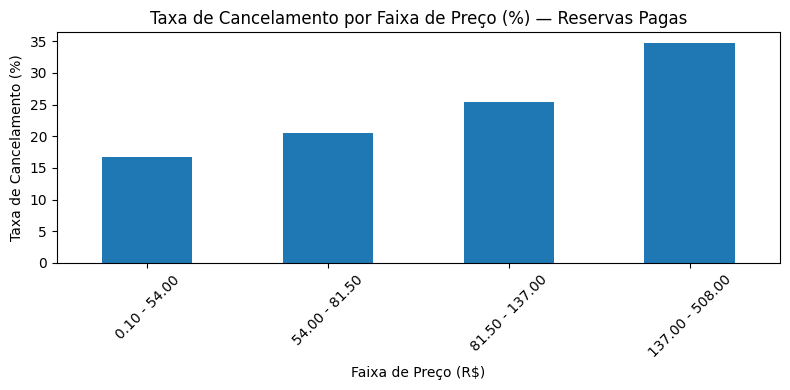

In [36]:
if df_original is not None:
    # Filtra apenas reservas pagas (receita/noite > 0)
    df_pagas = df_original[df_original[COL_RECEITA_NOITE] > 0].copy()
    
    try:
        # Calcula quartis da receita/noite
        quartis = df_pagas[COL_RECEITA_NOITE].quantile([0.25, 0.5, 0.75, 1.0]).tolist()
        # Define faixas (bins) de preço incluindo valor mínimo
        bins = sorted(list(set([0.1] + quartis)))
        # Cria rótulos para cada faixa
        labels = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins)-1)]
        df_pagas["faixa_preco"] = pd.cut(df_pagas[COL_RECEITA_NOITE], bins=bins, labels=labels, include_lowest=True)
        
        # Agrupa por faixa e calcula taxa de cancelamento (%) e nº de reservas
        analise_preco = df_pagas.groupby("faixa_preco", observed=True).agg(
            taxa_cancelamento_pct=(COL_CANCELADO, lambda x: x.mean() * 100),
            n_reservas=(COL_CANCELADO, 'size')
        )
        
        # Exibe tabela e gráfico
        print("Taxa de cancelamento e N de reservas por faixa de preço (reservas pagas):")
        display(analise_preco)
        plotar_grafico('bar', analise_preco, 'Taxa de Cancelamento por Faixa de Preço (%) — Reservas Pagas', 'Faixa de Preço (R$)', 'Taxa de Cancelamento (%)')
    except Exception as e:
        print(f"Não foi possível criar faixas de preço: {e}")


In [38]:
# MELHORIA: Controlando o efeito da antecedência na relação Preço x Cancelamento
if 'df_pagas' in locals():
    print("--- Análise Estratificada: A relação Preço x Cancelamento muda com a Antecedência? ---\n")
    
    # Estrato 1: Reservas com POUCA antecedência (< 30 dias)
    df_antec_baixa = df_pagas[df_pagas[COL_ANTECEDENCIA] < 30]
    taxa_preco_baixa_antec = df_antec_baixa.groupby(pd.qcut(df_antec_baixa[COL_RECEITA_NOITE], 4, duplicates='drop'))[COL_CANCELADO].agg(['mean', 'size'])
    print("--- Para reservas com MENOS de 30 dias de antecedência ---")
    print("Taxa de cancelamento (mean) e N (size) por quartil de preço:")
    display(taxa_preco_baixa_antec.rename(columns={'mean': 'taxa_cancelamento'}))
    
    # Estrato 2: Reservas com MUITA antecedência (>= 30 dias)
    df_antec_alta = df_pagas[df_pagas[COL_ANTECEDENCIA] >= 30]
    taxa_preco_alta_antec = df_antec_alta.groupby(pd.qcut(df_antec_alta[COL_RECEITA_NOITE], 4, duplicates='drop'))[COL_CANCELADO].agg(['mean', 'size'])
    print("\n--- Para reservas com 30 dias ou MAIS de antecedência ---")
    print("Taxa de cancelamento (mean) e N (size) por quartil de preço:")
    display(taxa_preco_alta_antec.rename(columns={'mean': 'taxa_cancelamento'}))

--- Análise Estratificada: A relação Preço x Cancelamento muda com a Antecedência? ---

--- Para reservas com MENOS de 30 dias de antecedência ---
Taxa de cancelamento (mean) e N (size) por quartil de preço:


C:\Users\mrsilva\AppData\Local\Temp\ipykernel_4476\929638050.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_preco_baixa_antec = df_antec_baixa.groupby(pd.qcut(df_antec_baixa[COL_RECEITA_NOITE], 4, duplicates='drop'))[COL_CANCELADO].agg(['mean', 'size'])


,taxa_cancelamento,size
receita_por_noite,,
"(3.999, 46.4]",0.079422,3324
"(46.4, 68.0]",0.097925,3421
"(68.0, 119.0]",0.119899,3161
"(119.0, 508.0]",0.195144,3295



--- Para reservas com 30 dias ou MAIS de antecedência ---
Taxa de cancelamento (mean) e N (size) por quartil de preço:


C:\Users\mrsilva\AppData\Local\Temp\ipykernel_4476\929638050.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_preco_alta_antec = df_antec_alta.groupby(pd.qcut(df_antec_alta[COL_RECEITA_NOITE], 4, duplicates='drop'))[COL_CANCELADO].agg(['mean', 'size'])


,taxa_cancelamento,size
receita_por_noite,,
"(0.259, 60.16]",0.280882,4760
"(60.16, 92.0]",0.274386,4767
"(92.0, 149.2]",0.322045,4754
"(149.2, 450.0]",0.427881,4756


### 2. Análise de Demanda e Padrões de Reserva: Quando e como os hóspedes reservam?
---

In [39]:
if df_original is not None:
    # Filtra apenas reservas confirmadas (não canceladas)
    df_confirmadas = df_original[df_original[COL_CANCELADO] == False].copy()
    print(f"Análises de demanda e receita serão feitas com {len(df_confirmadas):,} reservas confirmadas.".replace(",", "."))


Análises de demanda e receita serão feitas com 24.888 reservas confirmadas.


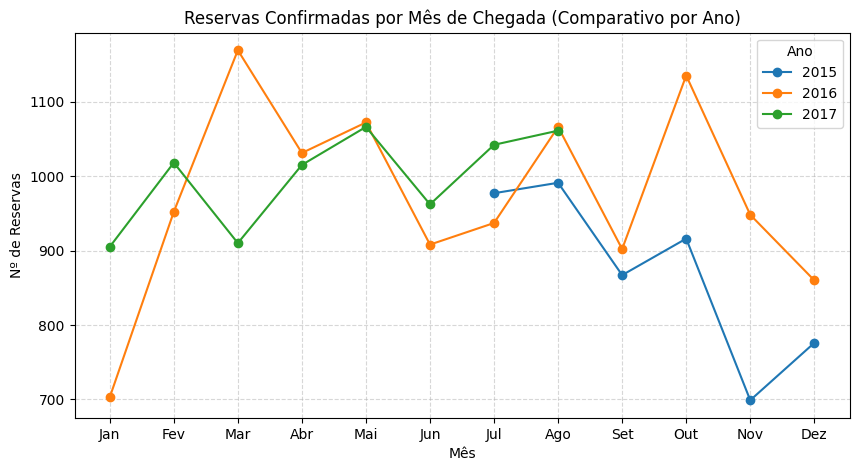

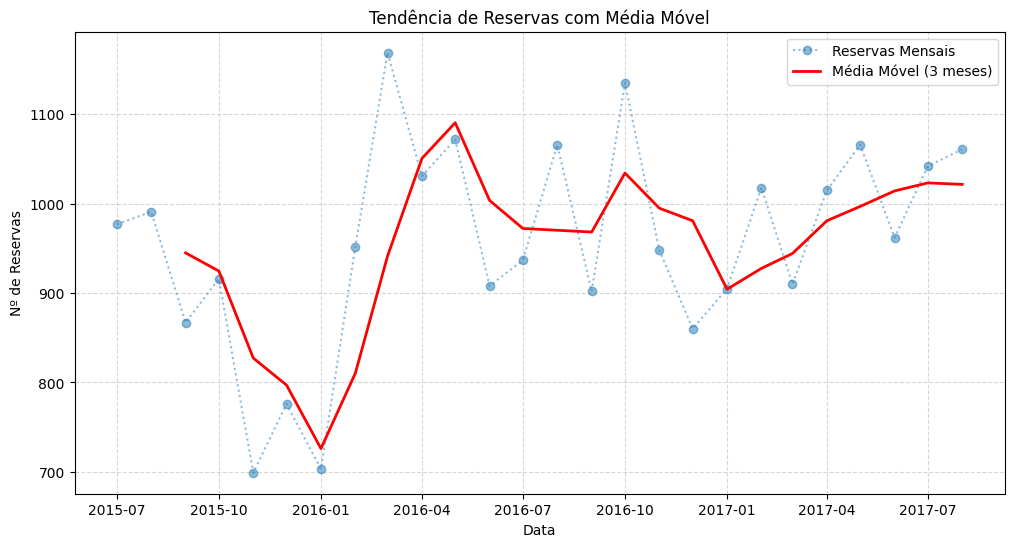

In [40]:
if 'df_confirmadas' in locals():
    mes_labels = ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"]
    
    # Sazonalidade Anual
    sazonalidade_anual = df_confirmadas.pivot_table(index=COL_MES_CHEGADA, columns=COL_ANO_CHEGADA, values="ano_mes", aggfunc="count")
    plt.figure(figsize=(10,5))
    for ano in sazonalidade_anual.columns:
        plt.plot(sazonalidade_anual.index, sazonalidade_anual[ano], marker="o", label=str(ano))
    plt.title("Reservas Confirmadas por Mês de Chegada (Comparativo por Ano)")
    plt.xlabel("Mês")
    plt.ylabel("Nº de Reservas")
    plt.xticks(ticks=range(1,13), labels=mes_labels)
    plt.legend(title="Ano")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Tendência com Média Móvel
    reservas_mensais = df_confirmadas.groupby('ano_mes').size()
    reservas_mensais_mm3 = reservas_mensais.rolling(window=3).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(reservas_mensais.index, reservas_mensais.values, label='Reservas Mensais', alpha=0.5, marker='o', linestyle=':')
    plt.plot(reservas_mensais_mm3.index, reservas_mensais_mm3.values, label='Média Móvel (3 meses)', color='red', linewidth=2)
    plt.title('Tendência de Reservas com Média Móvel')
    plt.xlabel('Data')
    plt.ylabel('Nº de Reservas')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

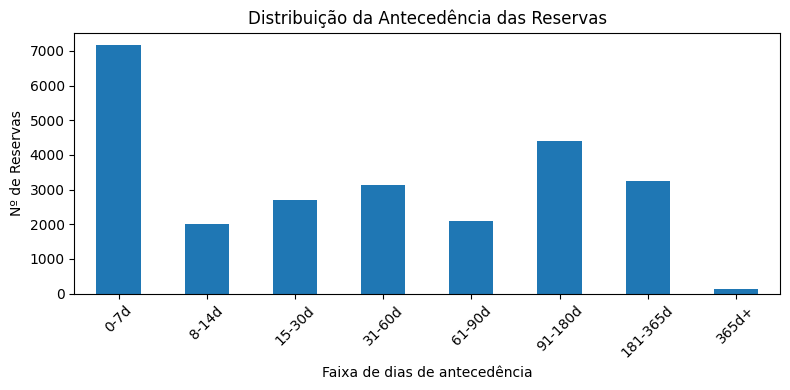

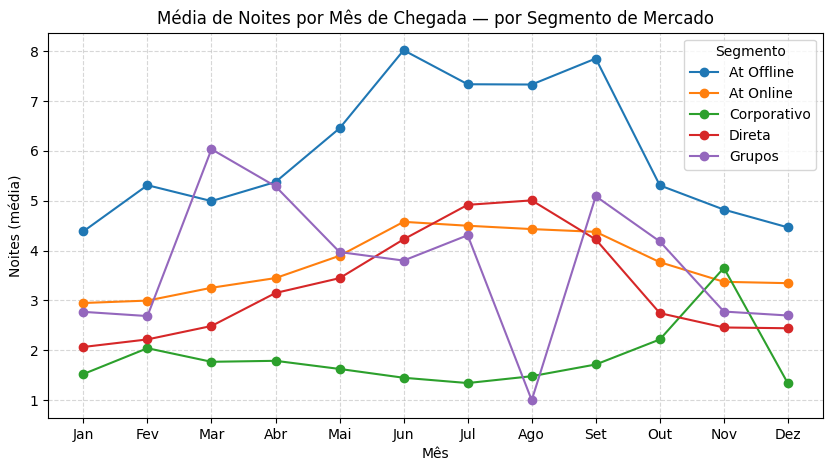

In [41]:
if 'df_confirmadas' in locals():
    # Distribuição da Antecedência
    bins = [0, 7, 14, 30, 60, 90, 180, 365, np.inf]
    labels = ["0-7d", "8-14d", "15-30d", "31-60d", "61-90d", "91-180d", "181-365d", "365d+"]
    df_confirmadas["faixa_antecedencia"] = pd.cut(df_confirmadas[COL_ANTECEDENCIA], bins=bins, labels=labels, right=False)
    antecedencia_tab = df_confirmadas["faixa_antecedencia"].value_counts().sort_index()
    plotar_grafico('bar', antecedencia_tab, 'Distribuição da Antecedência das Reservas', 'Faixa de dias de antecedência', 'Nº de Reservas')

    # Variação da estadia (LOS) por mês e segmento
    pivot_los = df_confirmadas.pivot_table(index=COL_MES_CHEGADA, columns=COL_SEGMENTO, values="total_noites", aggfunc="mean").reindex(range(1,13))
    plt.figure(figsize=(10,5))
    for seg in pivot_los.columns:
        plt.plot(pivot_los.index, pivot_los[seg], marker="o", label=str(seg))
    plt.title("Média de Noites por Mês de Chegada — por Segmento de Mercado")
    plt.xlabel("Mês")
    plt.ylabel("Noites (média)")
    plt.xticks(ticks=range(1,13), labels=["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"])
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Segmento")
    plt.show()


--- Análise da Participação na Receita por Fidelidade do Cliente (Reservas Confirmadas) ---


,receita_total,n_reservas_confirmadas,percentual_receita
tipo_hospede,,,
Primeira Reserva,10304224.74,23327,97.211444
Cliente Recorrente,295581.57,1561,2.788556


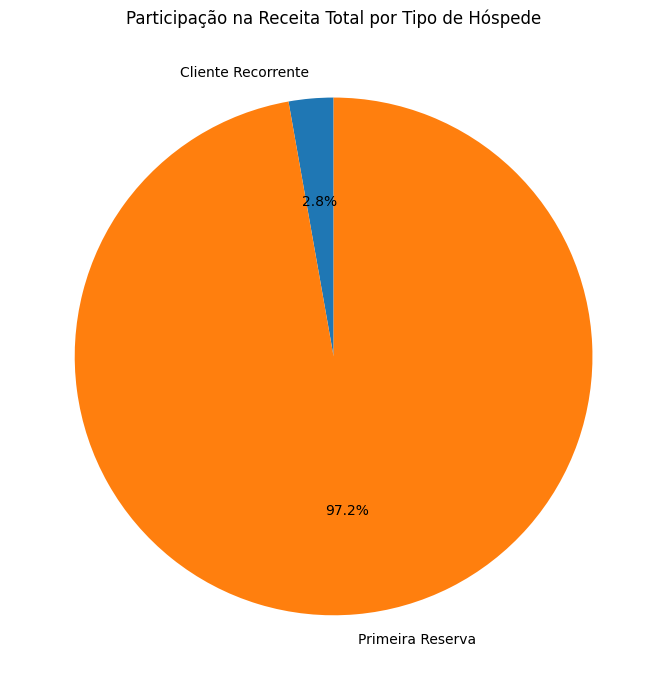

In [43]:
if 'tipo_hospede' in df_original.columns:
    print("\n--- Análise da Participação na Receita por Fidelidade do Cliente (Reservas Confirmadas) ---")
    
    # Criar a coluna 'tipo_hospede' também no df_confirmadas
    df_confirmadas['tipo_hospede'] = df_confirmadas[COL_FIDELIDADE].map({0: 'Primeira Reserva', 1: 'Cliente Recorrente'})

    # Agrupar por tipo de hóspede e somar a receita
    analise_receita_fidelidade = df_confirmadas.groupby('tipo_hospede').agg(
        receita_total=('receita_total', 'sum'),
        n_reservas_confirmadas=('receita_total', 'size')
    )
    
    # Calcular o percentual de participação
    analise_receita_fidelidade['percentual_receita'] = (analise_receita_fidelidade['receita_total'] / analise_receita_fidelidade['receita_total'].sum()) * 100
    
    display(analise_receita_fidelidade.sort_values('receita_total', ascending=False))
    
    # Gera gráfico de pizza para visualizar a participação
    plotar_grafico(
        'pie',
        analise_receita_fidelidade['receita_total'],
        title='Participação na Receita Total por Tipo de Hóspede',
        xlabel='',
        ylabel='',
        figsize=(7, 7)
    )

### 3. Análise de Receita e Preço: Como podemos maximizar o valor de cada reserva?
---

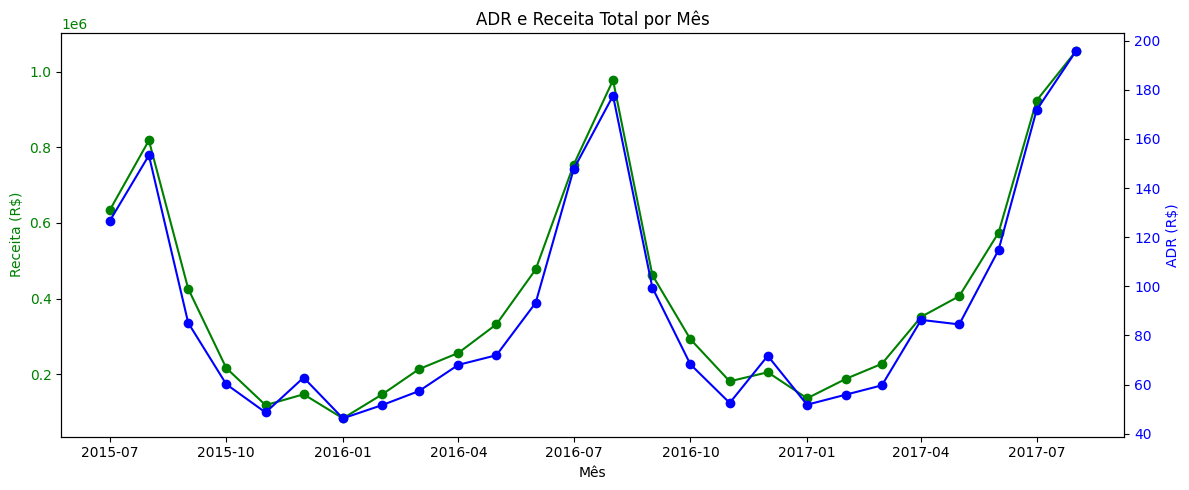

In [ ]:
# Métricas Mensais (ADR e Receita) 

if 'df_confirmadas' in locals():
    # Garante ordem temporal (YYYY-MM)
    metricas_mensais = (
        df_confirmadas
        .groupby("ano_mes", as_index=True)
        .agg(
            receita_total=("receita_total", "sum"),
            total_noites=("total_noites", "sum")
        )
        .sort_index()
    )

    # ADR = receita_total / total_noites (evita divisão por zero)
    metricas_mensais["ADR"] = (
        metricas_mensais["receita_total"] /
        metricas_mensais["total_noites"].replace(0, np.nan)
    )

    #  Gráfico combinado: ADR e Receita Total 
    fig, ax1 = plt.subplots(figsize=(12,5))

    # Eixo Y da esquerda → Receita Total
    ax1.plot(metricas_mensais.index, metricas_mensais['receita_total'],
             color="green", marker="o", label="Receita Total (R$)")
    ax1.set_xlabel("Mês")
    ax1.set_ylabel("Receita (R$)", color="green")
    ax1.tick_params(axis='y', labelcolor="green")

    # Eixo Y da direita → ADR
    ax2 = ax1.twinx()
    ax2.plot(metricas_mensais.index, metricas_mensais['ADR'],
             color="blue", marker="o", label="ADR (R$)")
    ax2.set_ylabel("ADR (R$)", color="blue")
    ax2.tick_params(axis='y', labelcolor="blue")

    # Título e layout
    plt.title("ADR e Receita Total por Mês")
    fig.tight_layout()
    plt.show()

else:
    print("Variável 'df_confirmadas' não encontrada. Garanta que filtrou reservas não canceladas.")


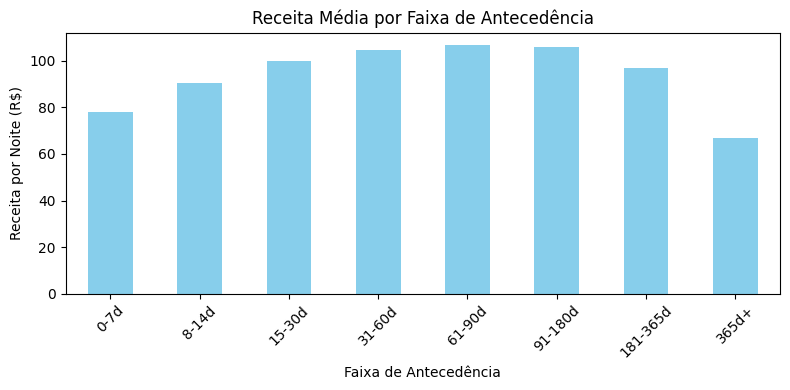


Receita média por composição (com crianças/bebês):
composicao
1A + 0C + 1B     49.500000
2A + 0C + 1B    110.647947
1A + 1C + 0B    121.767167
4A + 1C + 0B    134.060000
2A + 0C + 2B    135.735714
1A + 1C + 1B    137.505000
2A + 1C + 0B    142.606397
1A + 2C + 0B    153.010938
2A + 2C + 1B    156.935000
2A + 1C + 1B    160.384583
2A + 3C + 0B    162.847143
2A + 2C + 0B    174.541429
3A + 1C + 1B    183.500000
3A + 2C + 0B    184.571000
4A + 0C + 1B    190.000000
3A + 1C + 0B    190.762094
1A + 3C + 0B    202.700000
3A + 0C + 1B    204.740000
Name: receita_por_noite, dtype: float64


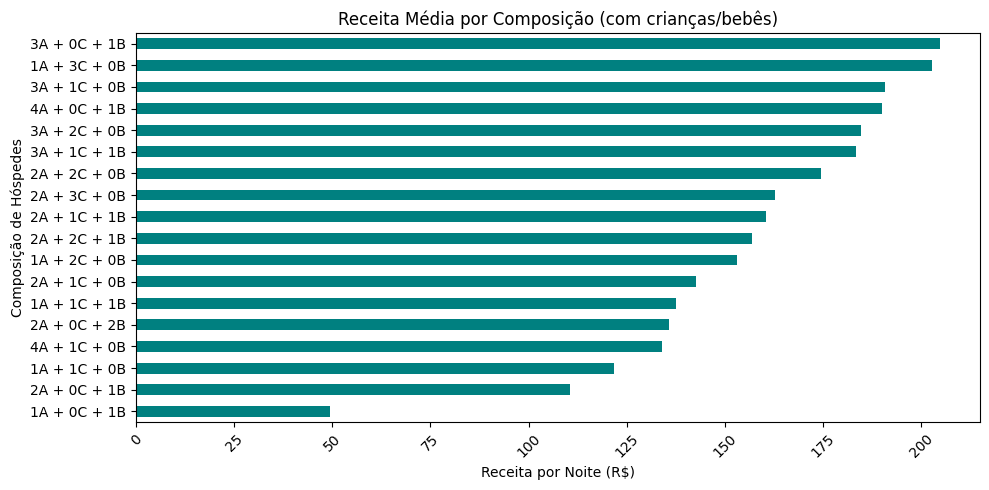


Receita média (Com filhos): 152.92
Receita média (Somente adultos): 88.01


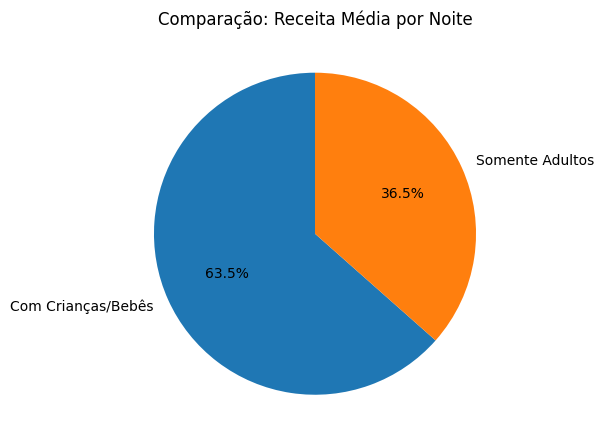

In [44]:
if 'df_confirmadas' in locals():
    # Receita por Faixa de Antecedência
    receita_antecedencia = df_confirmadas.groupby("faixa_antecedencia", observed=True)[COL_RECEITA_NOITE].mean()
    plotar_grafico('bar', receita_antecedencia, "Receita Média por Faixa de Antecedência", "Faixa de Antecedência", "Receita por Noite (R$)", color='skyblue')

    # Receita por Composição (com crianças/bebês)
    df_com_criancas = df_confirmadas[((df_confirmadas["criancas"] > 0) | (df_confirmadas["bebes"] > 0))].copy()
    df_com_criancas["composicao"] = df_com_criancas["adultos"].astype(str) + "A + " + df_com_criancas["criancas"].astype(str) + "C + " + df_com_criancas["bebes"].astype(str) + "B"
    receita_composicao = df_com_criancas.groupby("composicao")[COL_RECEITA_NOITE].mean().sort_values(ascending=True)
    print("\nReceita média por composição (com crianças/bebês):")
    print(receita_composicao)
    plotar_grafico('bar', receita_composicao, "Receita Média por Composição (com crianças/bebês)", "Receita por Noite (R$)", "Composição de Hóspedes", figsize=(10,5), color='teal', horizontal=True)
    
    # Comparativo: Com vs Sem Filhos
    media_com_filhos = df_confirmadas[(df_confirmadas["criancas"] > 0) | (df_confirmadas["bebes"] > 0)][COL_RECEITA_NOITE].mean()
    media_sem_filhos = df_confirmadas[(df_confirmadas["criancas"] == 0) & (df_confirmadas["bebes"] == 0)][COL_RECEITA_NOITE].mean()
    data_pie = pd.Series([media_com_filhos, media_sem_filhos], index=["Com Crianças/Bebês", "Somente Adultos"])
    print(f"\nReceita média (Com filhos): {media_com_filhos:.2f}")
    print(f"Receita média (Somente adultos): {media_sem_filhos:.2f}")
    plotar_grafico('pie', data_pie, "Comparação: Receita Média por Noite", "", "", figsize=(6,6),)

Receita Total e N por Segmento de Mercado


,receita_total,n_reservas
segmento_mercado,,
Corporativo,160016.54,1596
Grupos,408523.96,1439
Direta,2363616.60,5308
At Offline,2882539.19,5674
At Online,4785110.02,10871


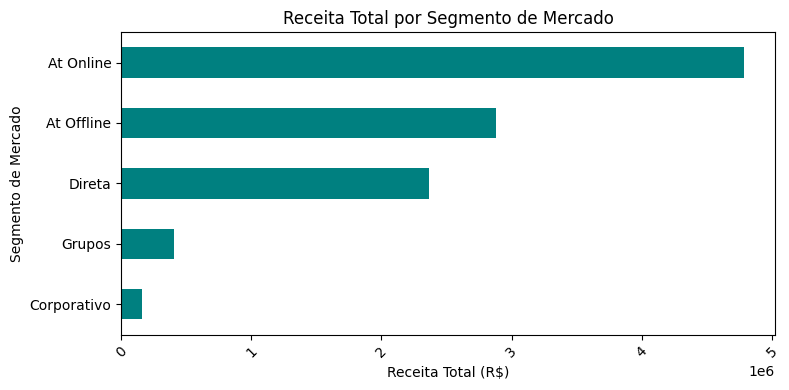


Receita Total e N por País (Top 15)


,receita_total,n_reservas
país,,
Swe,104292.49,192
Bra,110923.32,308
Pol,119229.45,246
Usa,137499.60,392
Ita,155175.88,339
Bel,169917.98,333
Nld,171151.70,416
Che,184173.92,306
Cn,218778.20,506


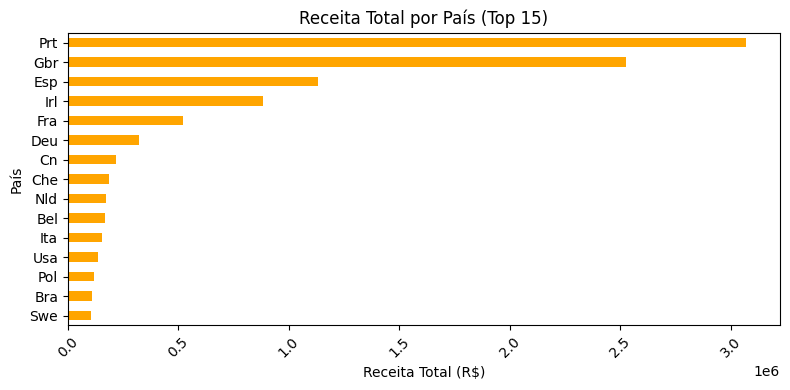


Receita Média e N por Nº de Pedidos Especiais


,receita_media,n_reservas
pedidos_especiais,,
0,81.920427,12265
1,101.432570,8406
2,113.161631,3402
3,131.821087,681
4,146.166033,121
5,141.573077,13


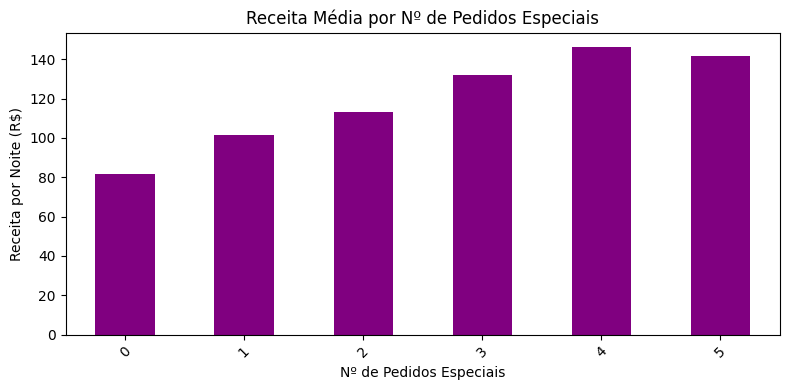

In [45]:
if 'df_confirmadas' in locals():
    # Receita por Segmento de Mercado (com N)
    receita_segmento = df_confirmadas.groupby(COL_SEGMENTO).agg(
        receita_total=('receita_total', 'sum'),
        n_reservas=('receita_total', 'size')
    ).sort_values('receita_total', ascending=True)
    print("Receita Total e N por Segmento de Mercado")
    display(receita_segmento)
    plotar_grafico('bar', receita_segmento, "Receita Total por Segmento de Mercado", "Receita Total (R$)", "Segmento de Mercado", color='teal', horizontal=True)

    # Receita por País (Top 15) (com N)
    receita_pais = df_confirmadas.groupby("país").agg(
        receita_total=('receita_total', 'sum'),
        n_reservas=('receita_total', 'size')
    ).nlargest(15, 'receita_total').sort_values('receita_total', ascending=True)
    print("\nReceita Total e N por País (Top 15)")
    display(receita_pais)
    plotar_grafico('bar', receita_pais, "Receita Total por País (Top 15)", "Receita Total (R$)", "País", color='orange', horizontal=True)

    # Receita por Pedidos Especiais (com N)
    analise_pedidos = df_confirmadas.groupby("pedidos_especiais").agg(
        receita_media=(COL_RECEITA_NOITE, 'mean'),
        n_reservas=(COL_RECEITA_NOITE, 'size')
    )
    print("\nReceita Média e N por Nº de Pedidos Especiais")
    display(analise_pedidos)
    plotar_grafico('bar', analise_pedidos, "Receita Média por Nº de Pedidos Especiais", "Nº de Pedidos Especiais", "Receita por Noite (R$)", color='purple')

--- Análise Financeira: Receita Realizada vs. Receita Perdida por Cancelamentos ---

Receita Realizada (reservas concluídas): R$ 10.599.806,31
Receita Perdida (devido a cancelamentos): R$ 4.843.585,39
----------------------------------------------------------
Receita Potencial Total (todas as reservas): R$ 15.443.391,70

Percentual da Receita Potencial perdida por cancelamentos: 31.36%


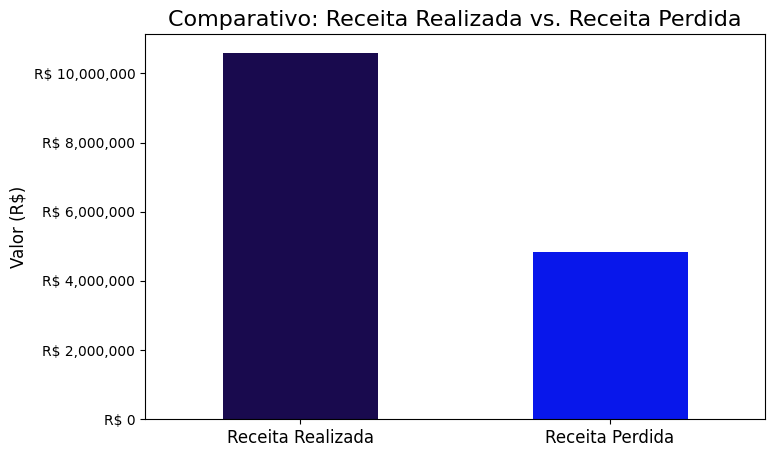

In [46]:
if df_original is not None and 'receita_total' in df_original.columns:
    print("--- Análise Financeira: Receita Realizada vs. Receita Perdida por Cancelamentos ---")
    
    # Calcula a Receita Realizada (reservas não canceladas)
    receita_realizada = df_original[df_original[COL_CANCELADO] == False]['receita_total'].sum()
    
    # Calcula a Receita Perdida (reservas canceladas)
    receita_perdida = df_original[df_original[COL_CANCELADO] == True]['receita_total'].sum()
    
    # Calcula a Receita Potencial Total
    receita_potencial_total = receita_realizada + receita_perdida # ou df_original['receita_total'].sum()
    
    # Calcula o Percentual de Perda
    if receita_potencial_total > 0:
        percentual_perda = (receita_perdida / receita_potencial_total) * 100
    else:
        percentual_perda = 0

    print(f"\nReceita Realizada (reservas concluídas): R$ {receita_realizada:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"Receita Perdida (devido a cancelamentos): R$ {receita_perdida:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    print("----------------------------------------------------------")
    print(f"Receita Potencial Total (todas as reservas): R$ {receita_potencial_total:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"\nPercentual da Receita Potencial perdida por cancelamentos: {percentual_perda:.2f}%")

    plt.figure(figsize=(8, 5))
    receitas = pd.Series([receita_realizada, receita_perdida], index=['Receita Realizada', 'Receita Perdida'])
    receitas.plot(kind='bar', color=["#190A4E", "#0817EB"])
    plt.title('Comparativo: Receita Realizada vs. Receita Perdida', fontsize=16)
    plt.ylabel('Valor (R$)', fontsize=12)
    plt.xticks(rotation=0, fontsize=12)
    plt.gca().yaxis.set_major_formatter('R$ {x:,.0f}')
    plt.show()

else:
    print("DataFrame 'df_original' ou coluna 'receita_total' não encontrados.")

In [ ]:
if df_original is not None:
    # Calcula a receita média por reserva para cada status (cancelada vs. confirmada)
    comparativo_valor_medio = df_original.groupby(COL_CANCELADO)['receita_total'].agg(['mean', 'size'])
    
    comparativo_valor_medio.index = comparativo_valor_medio.index.map({True: 'Cancelada', False: 'Confirmada'})
    
    print("--- Comparativo do Valor Médio por Reserva ---")
    display(comparativo_valor_medio.rename(columns={'mean': 'receita_media_por_reserva', 'size': 'n_reservas'}))

--- Comparativo do Valor Médio por Reserva ---


,receita_media_por_reserva,n_reservas
reserva_cancelada_bool,,
Confirmada,425.900286,24888
Cancelada,614.824243,7878


In [47]:
if df_original is not None:
    # Definido 'alto valor' como qualquer reserva com valor acima da média das que foram confirmadas.
    valor_medio_confirmada = 425.90

    # Filtrar o DataFrame para isolar apenas as reservas que foram CANCELADAS e eram de ALTO VALOR
    reservas_valiosas_perdidas = df_original[
        (df_original[COL_CANCELADO] == True) &
        (df_original['receita_total'] > valor_medio_confirmada)
    ]

    print(f"--- Perfil das {len(reservas_valiosas_perdidas)} Reservas de Alto Valor que Foram Perdidas ---")

    # De qual segmento de mercado elas vêm?
    print("\n--- Perfil por Segmento de Mercado ---")
    display(reservas_valiosas_perdidas['segmento_mercado'].value_counts(normalize=True).mul(100).round(2).to_frame())

    # Elas são feitas com muita antecedência?
    print("\n--- Perfil por Tempo de Antecedência (em dias) ---")
    display(reservas_valiosas_perdidas['tempo_antecedencia'].describe().to_frame())

    # São para estadias mais longas?
    print("\n--- Perfil por Duração da Estadia (em noites) ---")
    display(reservas_valiosas_perdidas['total_noites'].describe().to_frame())
    
    # São de clientes recorrentes ou novos?
    print("\n--- Perfil por Tipo de Hóspede ---")
    display(reservas_valiosas_perdidas['tipo_hospede'].value_counts(normalize=True).mul(100).round(2).to_frame())

--- Perfil das 4131 Reservas de Alto Valor que Foram Perdidas ---

--- Perfil por Segmento de Mercado ---


,proportion
segmento_mercado,
At Online,76.52
At Offline,10.24
Direta,10.19
Grupos,2.13
Corporativo,0.92



--- Perfil por Tempo de Antecedência (em dias) ---


,tempo_antecedencia
count,4131.000000
mean,137.061486
std,90.913987
min,0.000000
25%,60.000000
50%,125.000000
75%,197.000000
max,450.000000



--- Perfil por Duração da Estadia (em noites) ---


,total_noites
count,4131.000000
mean,6.776809
std,3.406525
min,2.000000
25%,5.000000
50%,7.000000
75%,7.000000
max,56.000000



--- Perfil por Tipo de Hóspede ---


,proportion
tipo_hospede,
Primeira Reserva,99.66
Cliente Recorrente,0.34


# Matriz Impacto vs Esforço

| Impacto \ Esforço | **Baixo Esforço**           | **Médio Esforço**                     |
|-------------------|-----------------------------|----------------------------------------|
| **Alto Impacto**  | Política de Depósito Inteligente *(Vitória Rápida)* |  Programa de Fidelidade "Boas-Vindas" *(Estratégico)* |
| **Médio Impacto** |           X                  |  Precificação e Pacotes para Famílias *(Otimização)* |
